# Extremely Noisy 4-D STEM Strain Mapping Using Cycle Consistent Spatial Transforming Autoencoders (Experimental 4dstem)

## Package Installation

In [1]:
import sys
#!{sys.executable} -m pip install -i https://test.pypi.org/simple/ Auto4DSTEM==0.7.1
!{sys.executable} -m pip install -U Auto4DSTEM

## Package Loading

In [2]:
%load_ext autoreload
%autoreload 2
import os
import torch
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from cmcrameri import cm
# from Auto4DSTEM.src.auto4dstem.Data.DataProcess import data_translated
# from Auto4DSTEM.src.auto4dstem.nn.Train_Function import TrainClass
# from Auto4DSTEM.src.auto4dstem.Viz.util import mask_class, upsample_mask, center_of_mass,\
#                                 translate_base, select_points, generate_classification
# from Auto4DSTEM.src.auto4dstem.Viz.viz import set_format_Auto4D, visualize_real_4dstem
from auto4dstem.Data.DataProcess import data_translated
from auto4dstem.nn.Train_Function import TrainClass
from auto4dstem.Viz.util import mask_class, upsample_mask, center_of_mass,\
                                translate_base, select_points, generate_classification
from auto4dstem.Viz.viz import set_format_Auto4D, visualize_real_4dstem
from m3util.util.IO import make_folder, download_files_from_txt

In [3]:
torch.__version__

'2.1.0+cu121'

In [4]:
import cv2
cv2.__version__

'4.10.0'

## Device Setting

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


## Visualization Format

In [6]:
set_format = set_format_Auto4D()
pylab.rcParams.update(set_format)

In [7]:
# ignore warning scripts
warnings.filterwarnings('ignore') 

## Download Data and Pre-Trained Models

In [8]:
folder_name = 'Experimental_4dstem/Extremely_Noisy_4DSTEM_Strain_Mapping_Using_CC_ST_AE_Experimental'
file_download =  "Experimental_4dstem/Experimental_label_weights_affine_para"

In [9]:
download_files_from_txt(file_download,folder_name)

  6%|████                                                                     | 1/18 [00:00<00:06,  2.46it/s]

File already exists: Rot512_1st_training_strain_rotation_weights.pkl


 11%|████████                                                                 | 2/18 [00:00<00:06,  2.37it/s]

File already exists: analysis_exp_2D__strain_ws2wse2.h5


 17%|████████████▏                                                            | 3/18 [00:01<00:06,  2.38it/s]

File already exists: Rot512_1st_training_translation_weights.pkl


 22%|████████████████▏                                                        | 4/18 [00:01<00:05,  2.39it/s]

File already exists: WS2WSe2_2_train_process_rotation.npy


 28%|████████████████████▎                                                    | 5/18 [00:02<00:05,  2.35it/s]

File already exists: Rot512_classification.npy


 33%|████████████████████████▎                                                | 6/18 [00:02<00:04,  2.41it/s]

File already exists: WS2WSe2_1_train_process_classification.npy


 39%|████████████████████████████▍                                            | 7/18 [00:02<00:04,  2.40it/s]

File already exists: WS2WSe2_1_train_process_rotation.npy


 44%|████████████████████████████████▍                                        | 8/18 [00:03<00:04,  2.41it/s]

File already exists: WS2WSe2_1st_training_weights.pkl


 50%|████████████████████████████████████▌                                    | 9/18 [00:03<00:03,  2.31it/s]

File already exists: analysis_exp_2D_big_triangle__strain.h5


 56%|████████████████████████████████████████                                | 10/18 [00:04<00:03,  2.28it/s]

File already exists: WS2WSe2_2nd_training_weights.pkl


 61%|████████████████████████████████████████████                            | 11/18 [00:04<00:02,  2.34it/s]

File already exists: Rot512_1_train_process_scale_shear.npy


 67%|████████████████████████████████████████████████                        | 12/18 [00:05<00:02,  2.39it/s]

File already exists: Rot512_1_train_process_rotation.npy


 72%|████████████████████████████████████████████████████                    | 13/18 [00:05<00:02,  2.43it/s]

File already exists: WS2WSe2_2_train_process_scale_shear.npy


 78%|████████████████████████████████████████████████████████                | 14/18 [00:05<00:01,  2.36it/s]

File already exists: Rot512_1_train_process_generated_base.npy


 83%|████████████████████████████████████████████████████████████            | 15/18 [00:06<00:01,  2.33it/s]

File already exists: Rot512_1_train_process_translation.npy


 89%|████████████████████████████████████████████████████████████████        | 16/18 [00:06<00:00,  2.37it/s]

File already exists: data_x256_y256_raw.npy


 94%|████████████████████████████████████████████████████████████████████    | 17/18 [00:07<00:00,  2.43it/s]

File already exists: 01_22kx_CL1p5m_50umapt_spot9_rot15_x512_y512.npy


100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.38it/s]

File already exists: Rot512_translated_version.npy


## Visualize results in notebook

In [10]:
img_show = True
if img_show:
    %matplotlib inline
else:
    plt.ioff()

# $WS_2WSe_2$ 4-D STEM

## Build mask for training and generating results

### Build Mask

In [11]:
# set mask class
set_mask = mask_class(img_size=[120,120])
# generate mask 
mask_tensor, mask_list = set_mask.mask_ring(radius_1=12, radius_2 = 45)

## 1st Training Process 

### Set File Initial, Load Data and Pre-Trained Weights

In [12]:
data_path = os.path.abspath(f'{folder_name}/data_x256_y256_raw.npy')
file_name = 'WS2WSe2'

### Initialize the training class from real dataset

In [13]:
real_tc = TrainClass(data_path,
                 device = device,
                 crop = ((2,122),(2,122)),
                 transpose= (2,3,0,1),
                 background_intensity =  False,
                 standard_scale = 1.0,
                 en_original_step_size = [120, 120],
                 pool_list =  [4, 3, 2],
                 up_list = [2, 3, 4],
                 num_base = 2,
                 up_size = 480,
                 scale_limit = 0.05,
                 shear_limit = 0.1,
                 rotation_limit = 0.1,
                 crop_radius = 36,
                 fixed_mask = mask_list,
                 interpolate = False,
                 revise_affine = False,
                 folder_path = folder_name
                 )

## Load pretrained weight to neural network

In [14]:
weight_path = f'{folder_name}/{file_name}_1st_training_weights.pkl'
real_tc.load_pretrained_weight(weight_path)

## Generate and save results

In [15]:
# set batch size and load dataset into DataLoader
real_tc.batch_size = 256
real_tc.predict(train_process='1',
               save_rotation = True,
               save_classification = True,
               file_name=file_name)

100%|██████████████████████████████████████████████████████████████████████| 256/256 [01:55<00:00,  2.21it/s]


## Initialize visual result class
### Set hyper parameters of the class

In [16]:
classification_path = f'{folder_name}/{file_name}_1_train_process_classification.npy'
rotation_1st_path = f'{folder_name}/{file_name}_1_train_process_rotation.npy'
classification_1 = np.load(classification_path)

## Show 6 examples of training results (Put this process into Package)

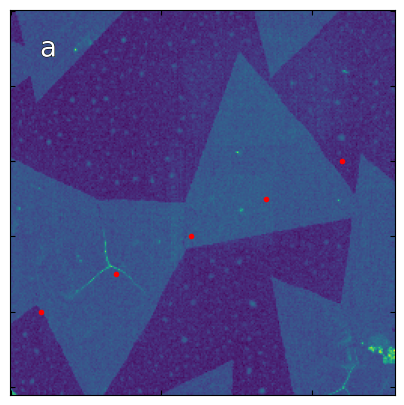

In [17]:
rxs = np.linspace(220,20,5).astype('int')
rys = np.linspace(100,200,5).astype('int')
real_tc.show_pickup_dots(x_axis = rxs,
                         y_axis = rys,
                         )

**Figure 1: Random select data from real-space.**

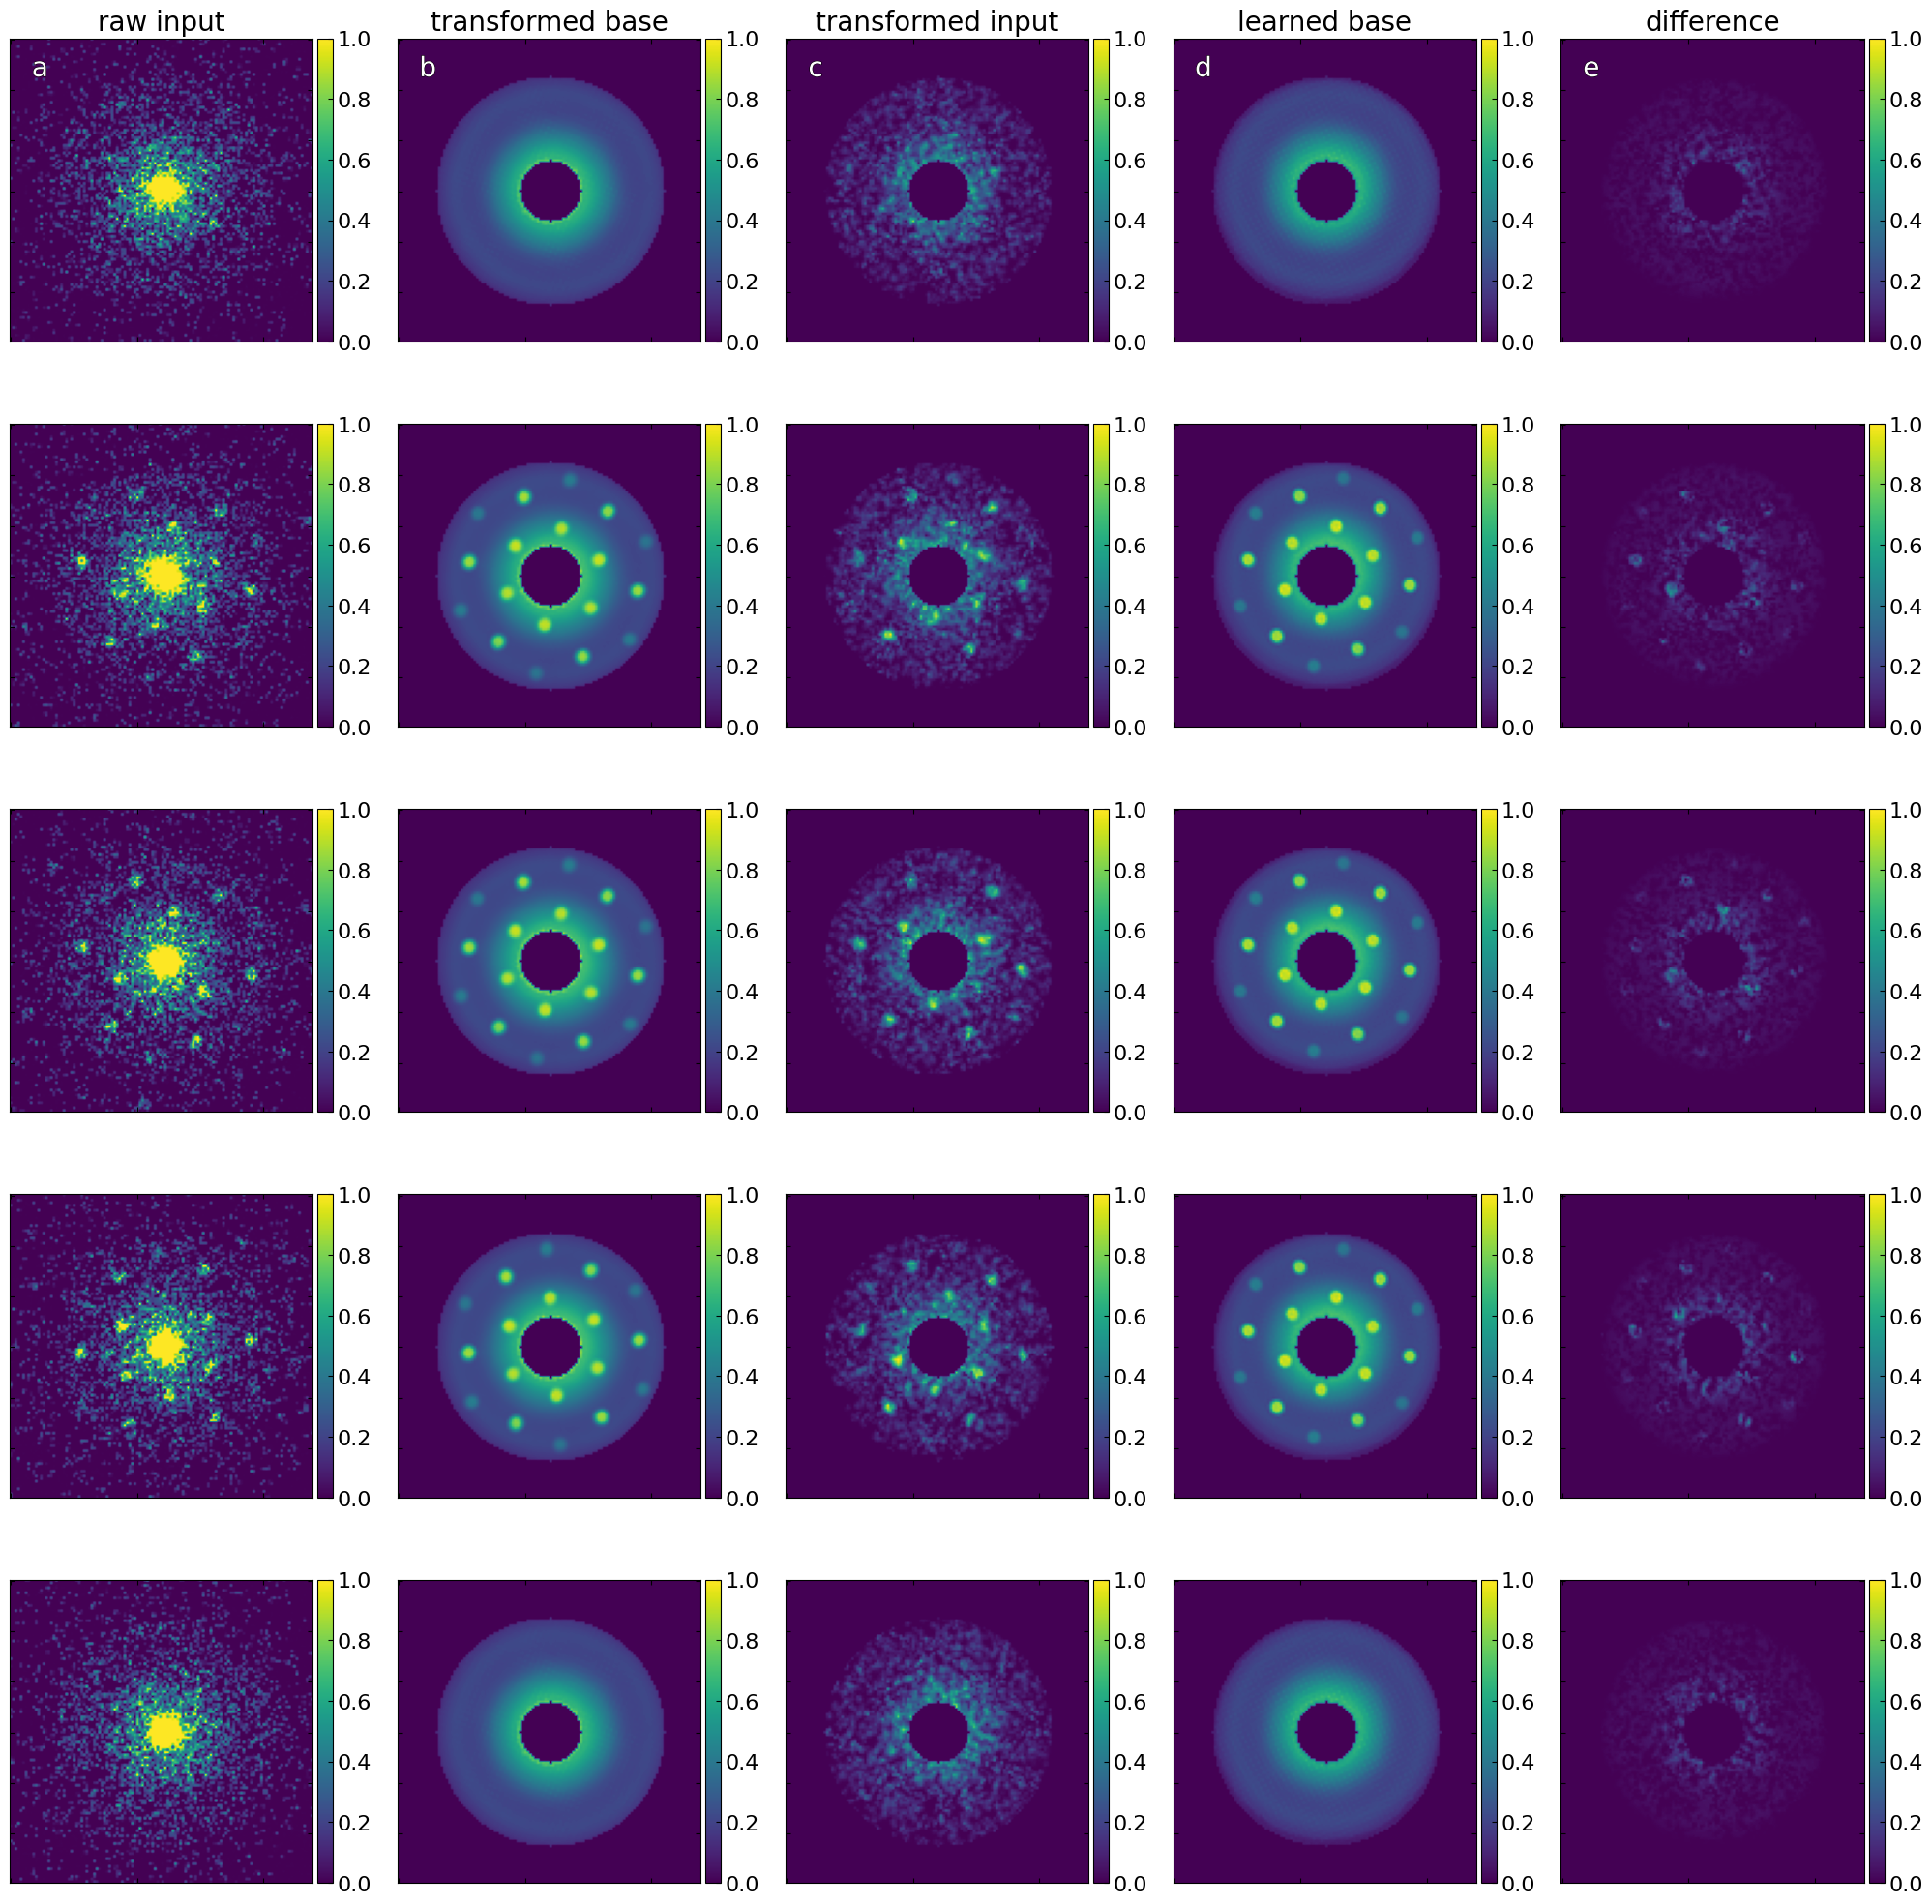

In [18]:
real_tc.show_transforming_sample(mask = mask_tensor,
                                file_name = file_name,
                                label_style= 'wb'
                                )

**Figure 2: Results of model prediction on selected diffraction images. a) The random input images go to CC-ST-AE. b) Corresponding learned bases generated by the model. c) Affine matrices measured by model applied on the input. d) Inverse of affine matrices applied on learned bases. e) Difference between transformed input and learned bases**

# 2nd Training Process

### Update train class parameter for data generating

In [19]:
# update number of base and interpolate for 2nd training process
real_tc.learned_rotation = rotation_1st_path
real_tc.adjust_learned_rotation = -10
real_tc.num_base = 1
real_tc.interpolate = True

### Generate dataset

In [20]:
real_tc.reset_dataset()

add image-rotation pair to whole dataset


100%|█████████████████████████████████████████████████████████████| 65536/65536 [00:00<00:00, 1966475.70it/s]


## Select diffraction image

In [21]:
sample_index = np.where(classification_1[:,0]==1)[0]

## Load pretrained weight to neural network

In [22]:
# update weights to reproduce 2nd training results
weight_path = f'{folder_name}/{file_name}_2nd_training_weights.pkl'
real_tc.load_pretrained_weight(weight_path)

## Generate and save results

In [23]:
real_tc.predict(train_process='2',
           save_strain = True,
           save_rotation = True,
           file_name=file_name,
           sample_index = sample_index)

100%|██████████████████████████████████████████████████████████████████████| 123/123 [01:14<00:00,  1.64it/s]


## Save trained affine parameter

## Visualize the results and compared with state-of-art

In [24]:
rotation_2nd_path = f'{folder_name}/{file_name}_2_train_process_rotation.npy'
strain_2nd_path = f'{folder_name}/{file_name}_2_train_process_scale_shear.npy'
rotation_2= np.load(rotation_2nd_path)
scale_shear_2 = np.load(strain_2nd_path)

## Visualization  for real dataset ( only with real data )

100%|███████████████████████████████████████████████████████████████| 31351/31351 [00:00<00:00, 56516.42it/s]


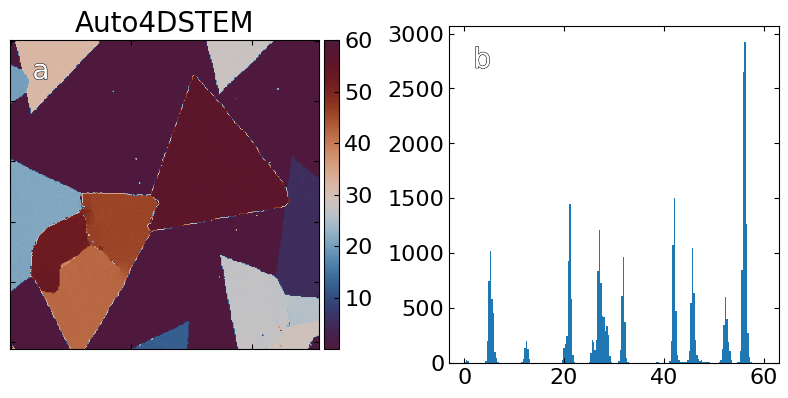

In [25]:
visual_result = visualize_real_4dstem(rotation = rotation_2,
                                       scale_shear = scale_shear_2,
                                       angle_shift = 6,
                                       shift_ref = 0,
                                       im_size = (256,256),
                                       bkg_position = 1,
                                       classification = classification_1,
                                       title_name = 'WS2WSe2',
                                       cmap_strain='viridis',
                                       cmap_rotation=cm.vikO,
                                       rotation_range = [0.01,60],
                                        )

**Figure 3: Rotation map and Histogram measured with Auto4DSTEM. a) Rotation map. b) Histogram.**

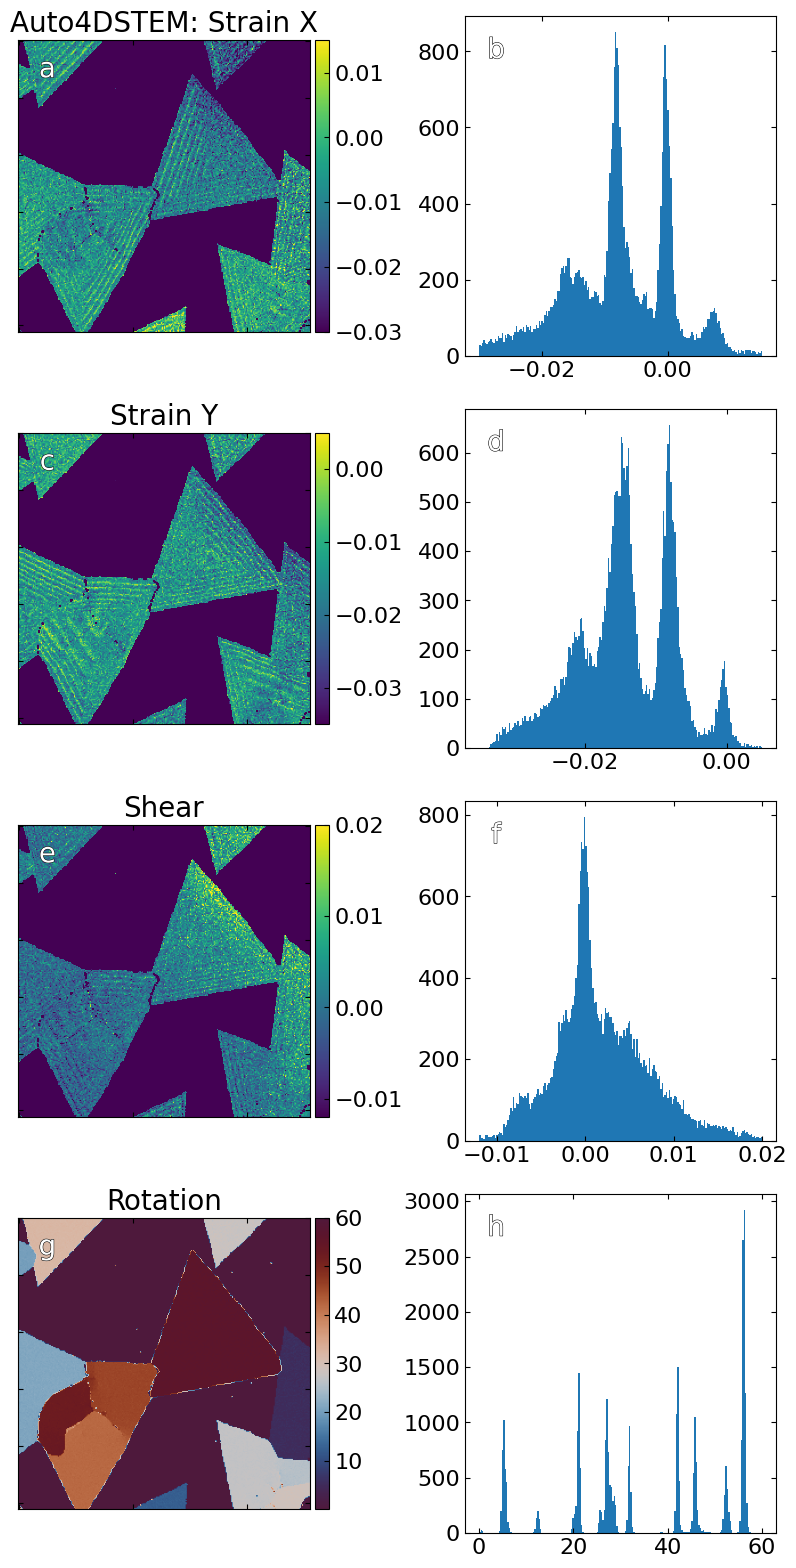

In [26]:
visual_result.visual_real_strain(label_style= 'wb')

**Figure 4: Strain maps of $WS_2WSe_2$ 4D-STEM measured with Auto4DSTEM. a) Strain map and b) histogram in direction $ε_{xx}$. c) Strain map and d) histogram in direction $ε_{yy}$. e) Strain map and f) histogram in direction $ε_{xy}$. g) Strain map and h) histogram in rotation.**

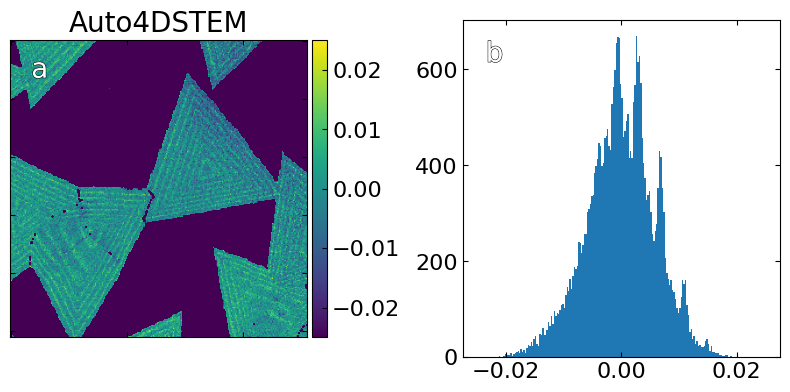

In [27]:
visual_result.visual_magnitude_of_strain(strain_range=[-0.025,0.025])

**Figure 5: Strain magitude mesaured with Auto4DSTEM. a) Strain magnitude mapping on $WS_2WSe_2$ 4D-STEM. b) Corresponding histogram of the strain magnitude.**

## Visualize for real dataset ( with py4dstem )

In [28]:
path_py4DSTEM = f'{folder_name}/analysis_exp_2D__strain_ws2wse2.h5'
visual_result.file_py4DSTEM = path_py4DSTEM

In [29]:
visual_result.reset_baseline()

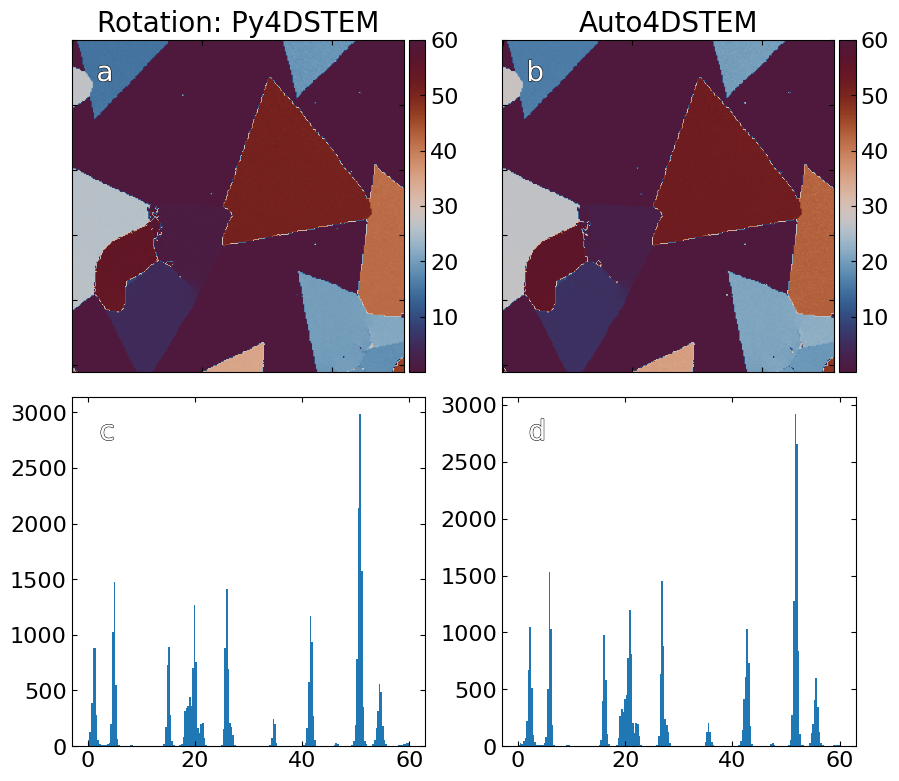

In [30]:
visual_result.reset_angle(angle_shift=42,
                         supplementary_angle= True)

**Figure 6: Rotation map and Histogram measured with Py4dSETM and Auto4DSTEM. a) Rotation map and c) histogram measured with Py4dSTEM. b) Rotation map and d) histogram measured with Auto4DSTEM.**

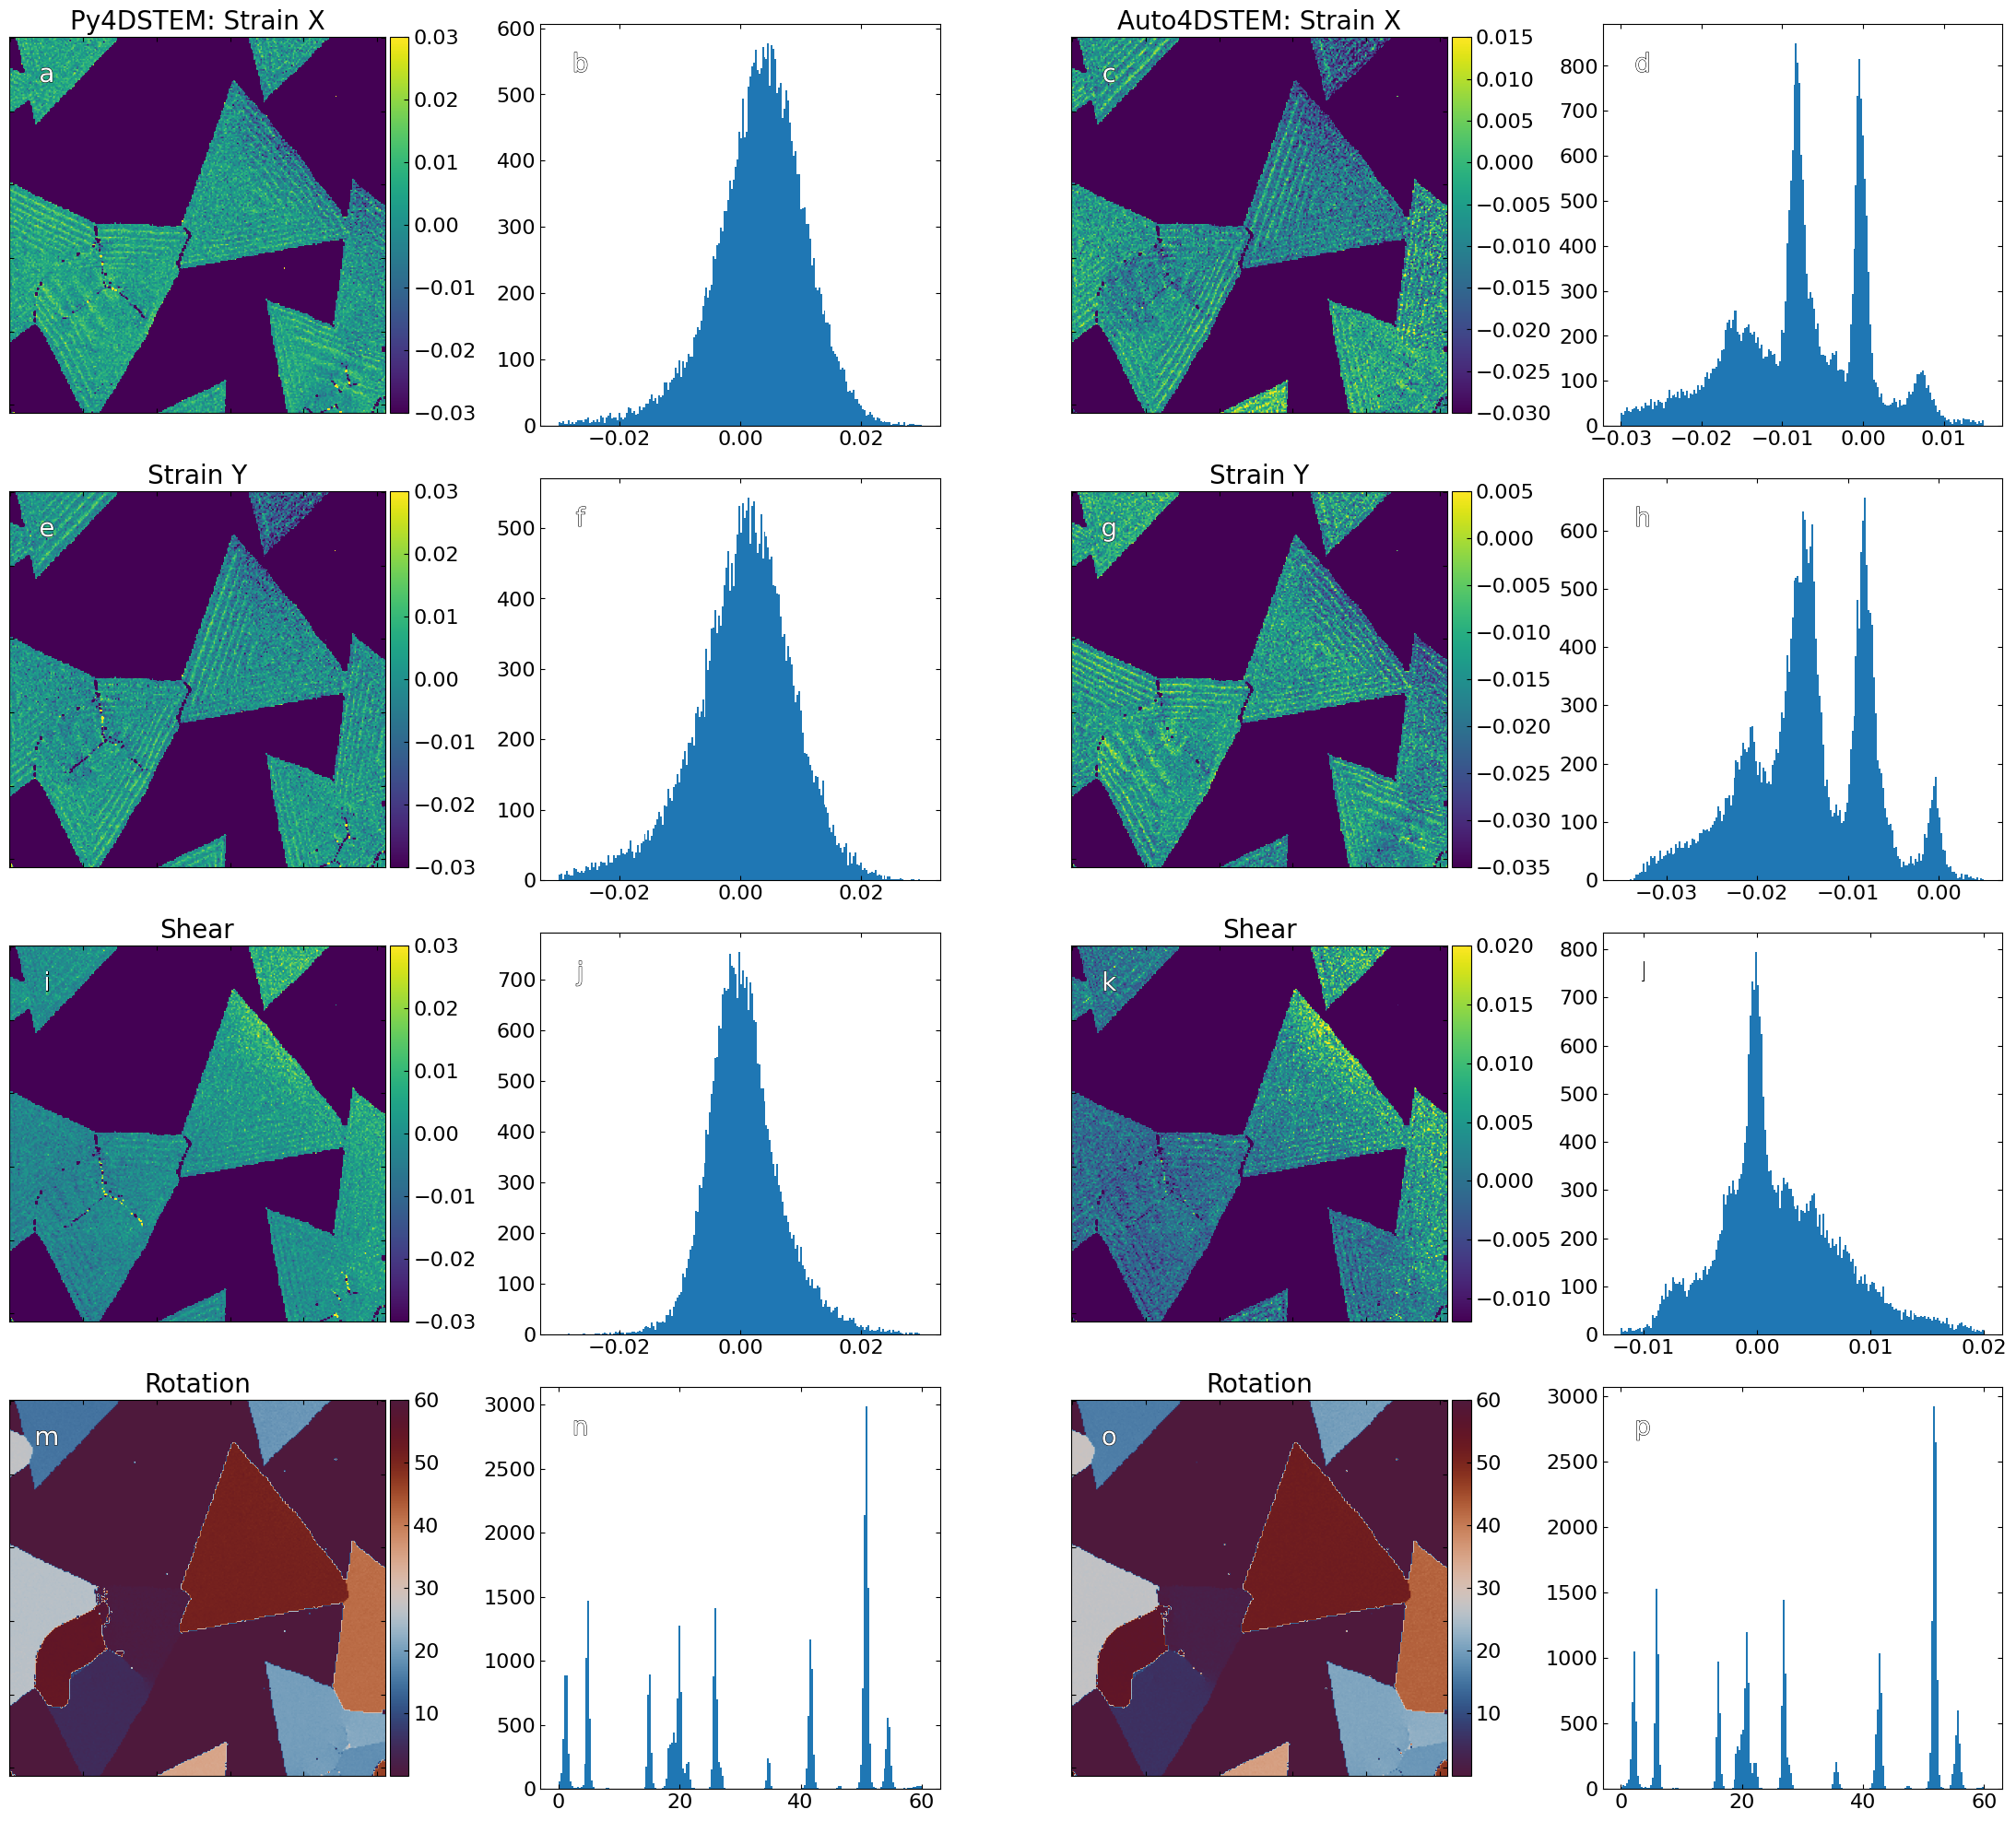

In [31]:
visual_result.visual_strain(strain_range_xx_cross=[-0.03,0.03],
                            strain_range_yy_cross=[-0.03,0.03],
                            strain_range_xy_cross=[-0.03,0.03])

**Figure 7: Strain maps of $WS_2WSe_2$ 4D-STEM measured with Py4DSTEM and Auto4DSTEM. a) Strain map and b) histogram in direction $ε_{xx}$ meansured with Py4DSTEM. e) Strain map and f) histogram in direction $ε_{yy}$ meansured with Py4DSTEM. i) Strain map and j) histogram in direction $ε_{xy}$ meansured with Py4DSTEM. m) Strain map and n) histogram in rotation meansured with Py4DSTEM. c) Strain map and d) histogram in direction $ε_{xx}$ meansured with Auto4DSTEM. g) Strain map and h) histogram in direction $ε_{yy}$ meansured with Auto4DSTEM. k) Strain map and l) histogram in direction $ε_{xy}$ meansured with Auto4DSTEM. o) Strain map and p) histogram in rotation meansured with Auto4DSTEM.**

In [32]:
visual_result.folder_name

'save_figures'

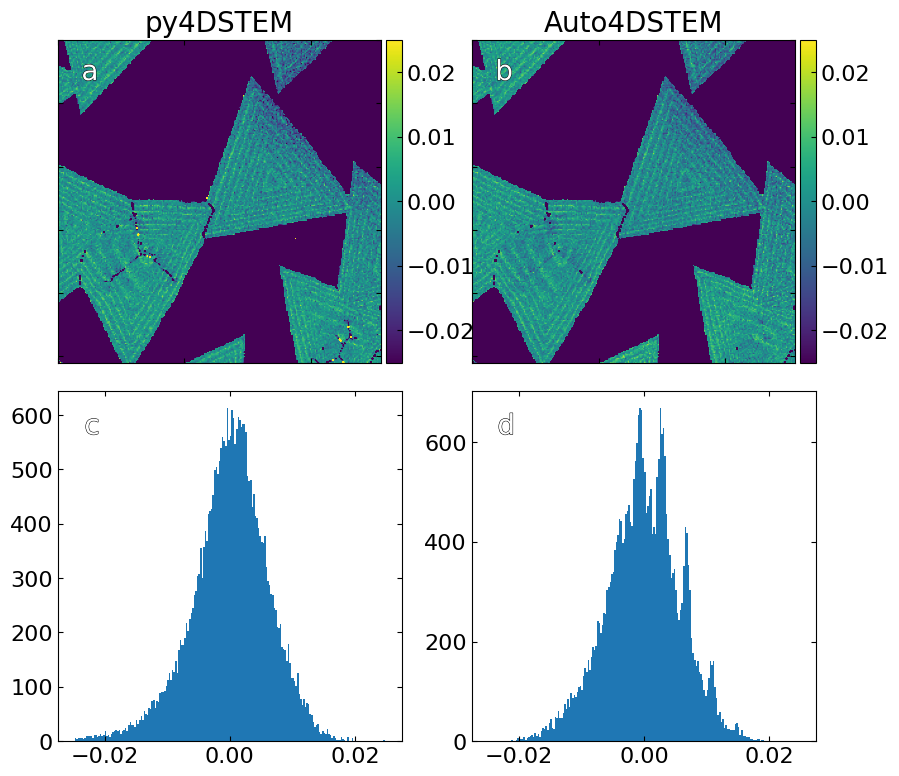

In [33]:
visual_result.visual_magnitude_of_strain(strain_range = [-0.025,0.025],
                                           ref_range = [-0.025,0.025])

**Figure 8: Strain magitude. a) Strain magnitude mapping on 4D-STEM and c) Corresponding histogram measursed with Py4DSTEM. b) Strain magnitude mapping on 4D-STEM and d) Corresponding histogram measursed with Auto4DSTEM.**

# Rot512 $WS_2WSe_2$ Experimental 4DSTEM
## 1st Training Process ( make beam centered)

### Build mask list for training

In [34]:
# set mask class
set_mask = mask_class(img_size=[120,120])
# generate mask 
mask_tensor, mask_list = set_mask.mask_single(radius=15)
up_mask_list = upsample_mask(mask_list,120,480)

## Set File Initial, Load Data and Pre-Trained Weights

In [35]:
data_path = os.path.abspath(f'{folder_name}/01_22kx_CL1p5m_50umapt_spot9_rot15_x512_y512.npy')
file_name = 'Rot512'

In [36]:
real_tc = TrainClass(data_path,
                 device = device,
                 crop = ((2,122),(2,122)),
                 transpose= (0,1,2,3),
                 background_intensity = False,
                 boundary_filter = True,
                 en_original_step_size = [120, 120],
                 de_original_step_size = [5, 5],
                 pool_list = [4, 3, 2],
                 up_list = [2, 3, 4],
                 scale = False,
                 shear = False,
                 rotation = False,
                 translation = True,
                 num_base=1,
                 up_size=480,
                 scale_limit = 0.05,
                 shear_limit = 0.1,
                 rotation_limit=0.05,
                 trans_limit = 0.15,
                 crop_radius = 32,
                 fixed_mask = mask_list,
                 interpolate = True,
                 revise_affine = False,
                 folder_path = folder_name
                 )

add sobel filter to whole dataset


100%|██████████████████████████████████████████████████████████████| 262144/262144 [01:22<00:00, 3176.83it/s]


### Reproduce translation matrices

In [37]:
weight_path = f'{folder_name}/{file_name}_1st_training_translation_weights.pkl'
real_tc.load_pretrained_weight(weight_path)

## Generate and save results

In [38]:
# set batch size and load dataset into DataLoader
real_tc.batch_size = 256
real_tc.predict(train_process='1',
               save_translation = True,
               save_base= True,
               file_name=file_name
               )

100%|████████████████████████████████████████████████████████████████████| 1024/1024 [10:09<00:00,  1.68it/s]


### Load translation result

In [39]:
translation_path = f'{folder_name}/{file_name}_1_train_process_translation.npy'
base_path = f'{folder_name}/{file_name}_1_train_process_generated_base.npy'
translation = np.load(translation_path)
test_base = np.load(base_path)

## Make generated base at the center 

In [40]:
test_base = torch.tensor(test_base.squeeze())
print(center_of_mass(test_base,up_mask_list[0],0))

(tensor(252.9097), tensor(226.2922))


## Adjust x, y coordinates to make beam centered

In [41]:
adj_x = -0.060434
adj_y = 0.056313
translate_base(adj_x,adj_y,torch.tensor(test_base), up_mask_list[0])

(tensor(240.0001), tensor(240.0001))

## Create modified translation parameter

In [42]:
# create translated matrix
trans_after_adjust = np.copy(translation)
trans_after_adjust[:,0] = trans_after_adjust[:,0]+adj_x
trans_after_adjust[:,1] = trans_after_adjust[:,1]+adj_y

## Generate translated dataset 

In [43]:
# if create_dataset is set True, will reproduce the translated 4dstem dataset, takes about 4 hours
create_dataset = False
if create_dataset:
    data_translated(data_path,
                    trans_after_adjust,
                    crop = ((2,122),(2,122)),
                    transpose = (0,1,2,3),
                    save_path = f'{folder_name}/{file_name}')

## Reproduce result of translated model
### Set train class for transformed dataset

In [44]:
data_dir = f'{folder_name}/{file_name}_translated_version.npy'

In [45]:
real_tc.data_dir = data_dir
real_tc.crop = ((0,120),(0,120))
real_tc.transpose = (0,1,2)
real_tc.standard_scale = 1.5
real_tc.up_threshold = 2000
real_tc.rotate_clockwise = False
real_tc.boundary_filter = False
real_tc.scale = True
real_tc.shear = True
real_tc.rotation = True
real_tc.translation = False

In [46]:
real_tc.reset_dataset()

### Set mask to separate diffraction images from background noise 

In [47]:
radius_list = [[23,96],[72,109],[108,73],[95,24],[46,11],[11,47]]
mask_tensor, mask_list = set_mask.mask_round(radius=8,center_list=radius_list)

### Select diffraction image

100%|█████████████████████████████████████████████████████████████| 262144/262144 [00:13<00:00, 19242.32it/s]


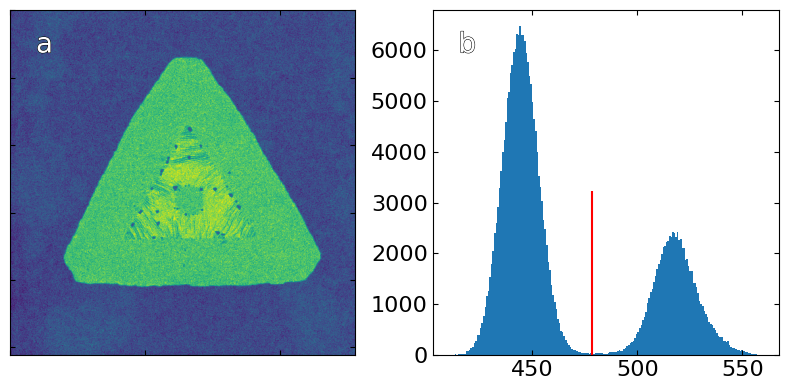

In [48]:
sample_index = select_points(real_tc.data_set,mask_tensor,threshold=478.3,clim=[410,560])

**Figure 9: Signal intensity mapping of Rot512 $WS_2WSe_2$ Experimental 4DSTEM. a) Intensity mapping on real-space of Rot512 $WS_2WSe_2$. b) Corresponding histogram of the mapping splitted by red threshold line.**

### Reproduce strain-mapping results with pretrained weights

In [49]:
weight_path = f'{folder_name}/{file_name}_1st_training_strain_rotation_weights.pkl'
real_tc.load_pretrained_weight(weight_path)

In [50]:
real_tc.batch_size = 256
real_tc.predict(sample_index = sample_index,
               train_process='1',
               save_rotation = True,
               save_strain = True,
               file_name=file_name,
               )

100%|██████████████████████████████████████████████████████████████████████| 315/315 [03:06<00:00,  1.69it/s]


## Generate correct format of classification 

In [51]:
# geneate cluster based on sample index
select_rot = generate_classification(sample_index,
                                    sample_position = 0,
                                    img_size = [512,512],
                                    save_file = True,
                                    file_path = f'{folder_name}/{file_name}')

## Visualization  for real dataset ( only with real data )

In [52]:
rotation_2nd = np.load(f'{folder_name}/{file_name}_1_train_process_rotation.npy')
scale_shear_2nd = np.load(f'{folder_name}/{file_name}_1_train_process_scale_shear.npy')
select_rot = np.load(f'{folder_name}/{file_name}_classification.npy')

100%|███████████████████████████████████████████████████████████████| 80499/80499 [00:01<00:00, 55710.91it/s]


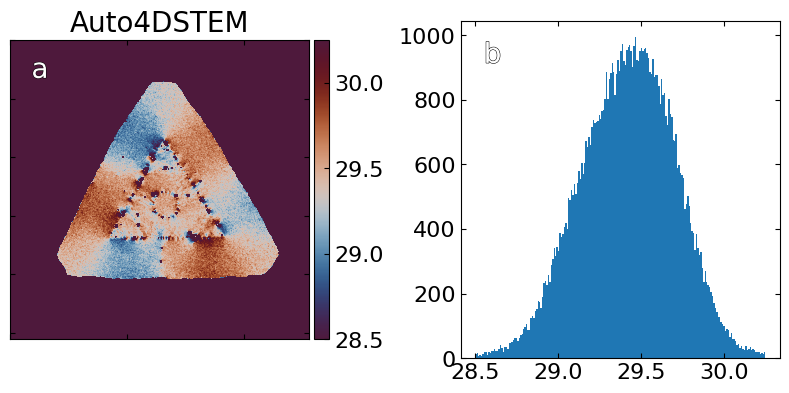

In [53]:
visual_result = visualize_real_4dstem(rotation = rotation_2nd,
                                           scale_shear = scale_shear_2nd,
                                           angle_shift = 30,
                                           shift_ref = 33,
                                           im_size = (512,512),
                                           bkg_position = 1,
                                           classification = select_rot,
                                           title_name = 'Rot512',
                                           cmap_strain = 'viridis',
                                           cmap_rotation=cm.vikO,
                                           rotation_range = [28.5,30.25],
                                            )

**Figure 10: Rotation map and Histogram measured with Auto4DSTEM. a) Rotation map. b) Histogram.**

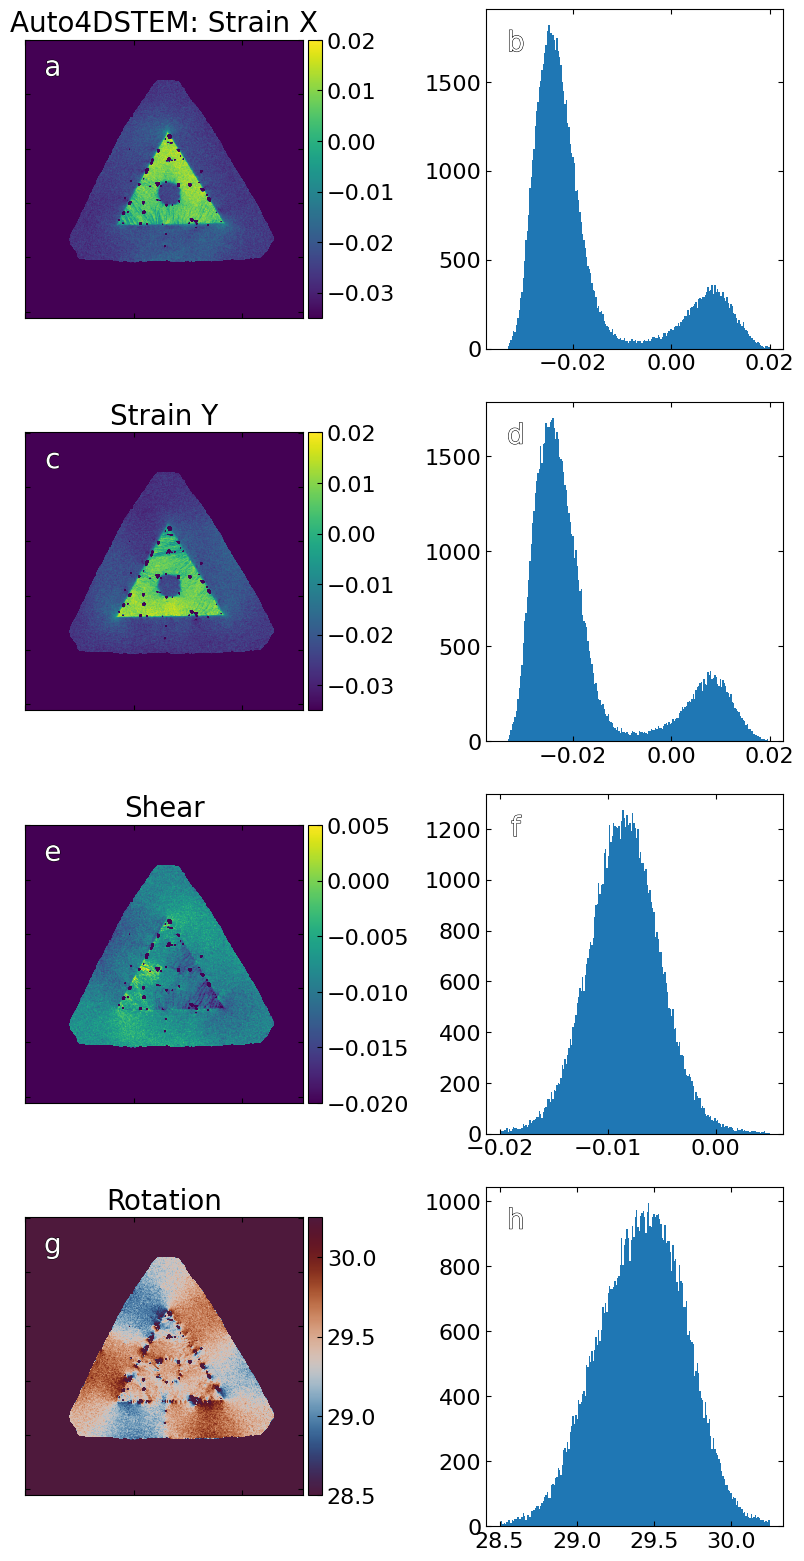

In [54]:
visual_result.visual_real_strain(strain_range_xx_ae=[-0.035,0.02],
                                 strain_range_yy_ae=[-0.035,0.02],
                                 strain_range_xy_ae=[-0.02,0.005],
                                 )

**Figure 11: Strain maps of  4D-STEM measured with Auto4DSTEM. a) Strain map and b) histogram in direction . c) Strain map and d) histogram in direction . e) Strain map and f) histogram in direction . g) Strain map and h) histogram in rotation.**

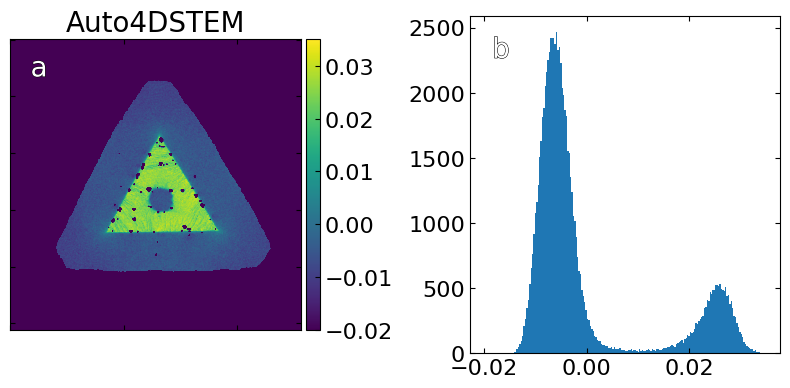

In [55]:
visual_result.visual_magnitude_of_strain(strain_range = [-0.02,0.035])

**Figure 12: Strain magitude mesaured with Auto4DSTEM. a) Strain magnitude mapping on  4D-STEM. b) Corresponding histogram of the strain magnitude.**

## Visualization  for result comparison ( with py4DSTEM )

In [56]:
path_py4DSTEM = f'{folder_name}/analysis_exp_2D_big_triangle__strain.h5'
visual_result.file_py4DSTEM = path_py4DSTEM

In [57]:
visual_result.reset_baseline()

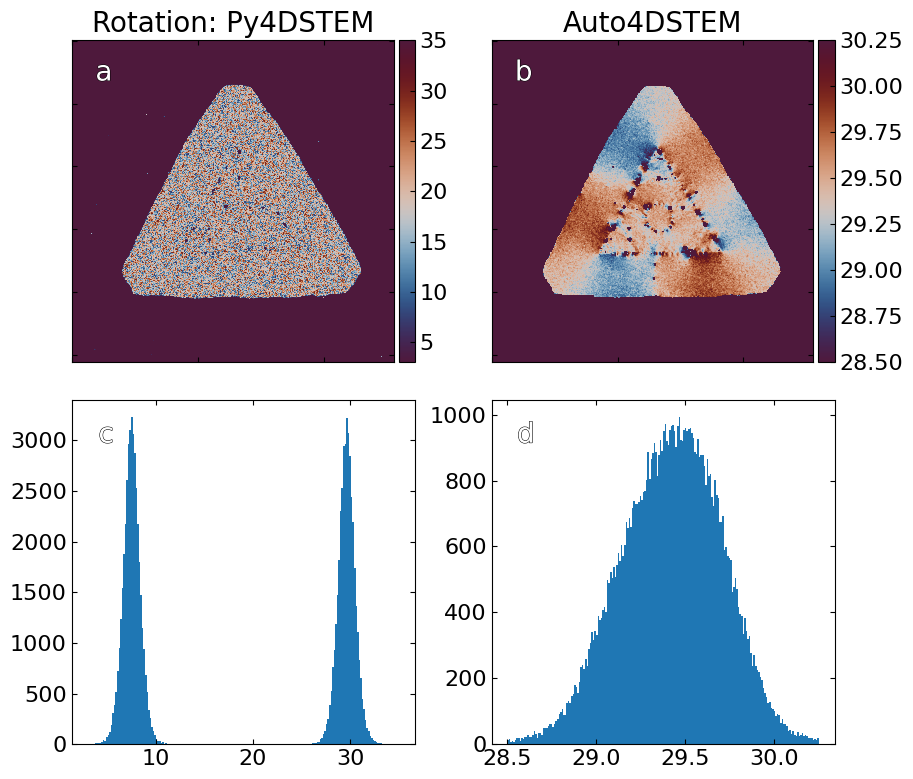

In [58]:
visual_result.reset_angle(angle_shift=30,
                          shift_ref=33,
                          rotation_range=[28.5,30.25],
                          ref_rotation_range=[3,35]
                         )

**Figure 13: Rotation map and Histogram measured with Py4dSETM and Auto4DSTEM. a) Rotation map and c) histogram measured with Py4dSTEM. b) Rotation map and d) histogram measured with Auto4DSTEM.**

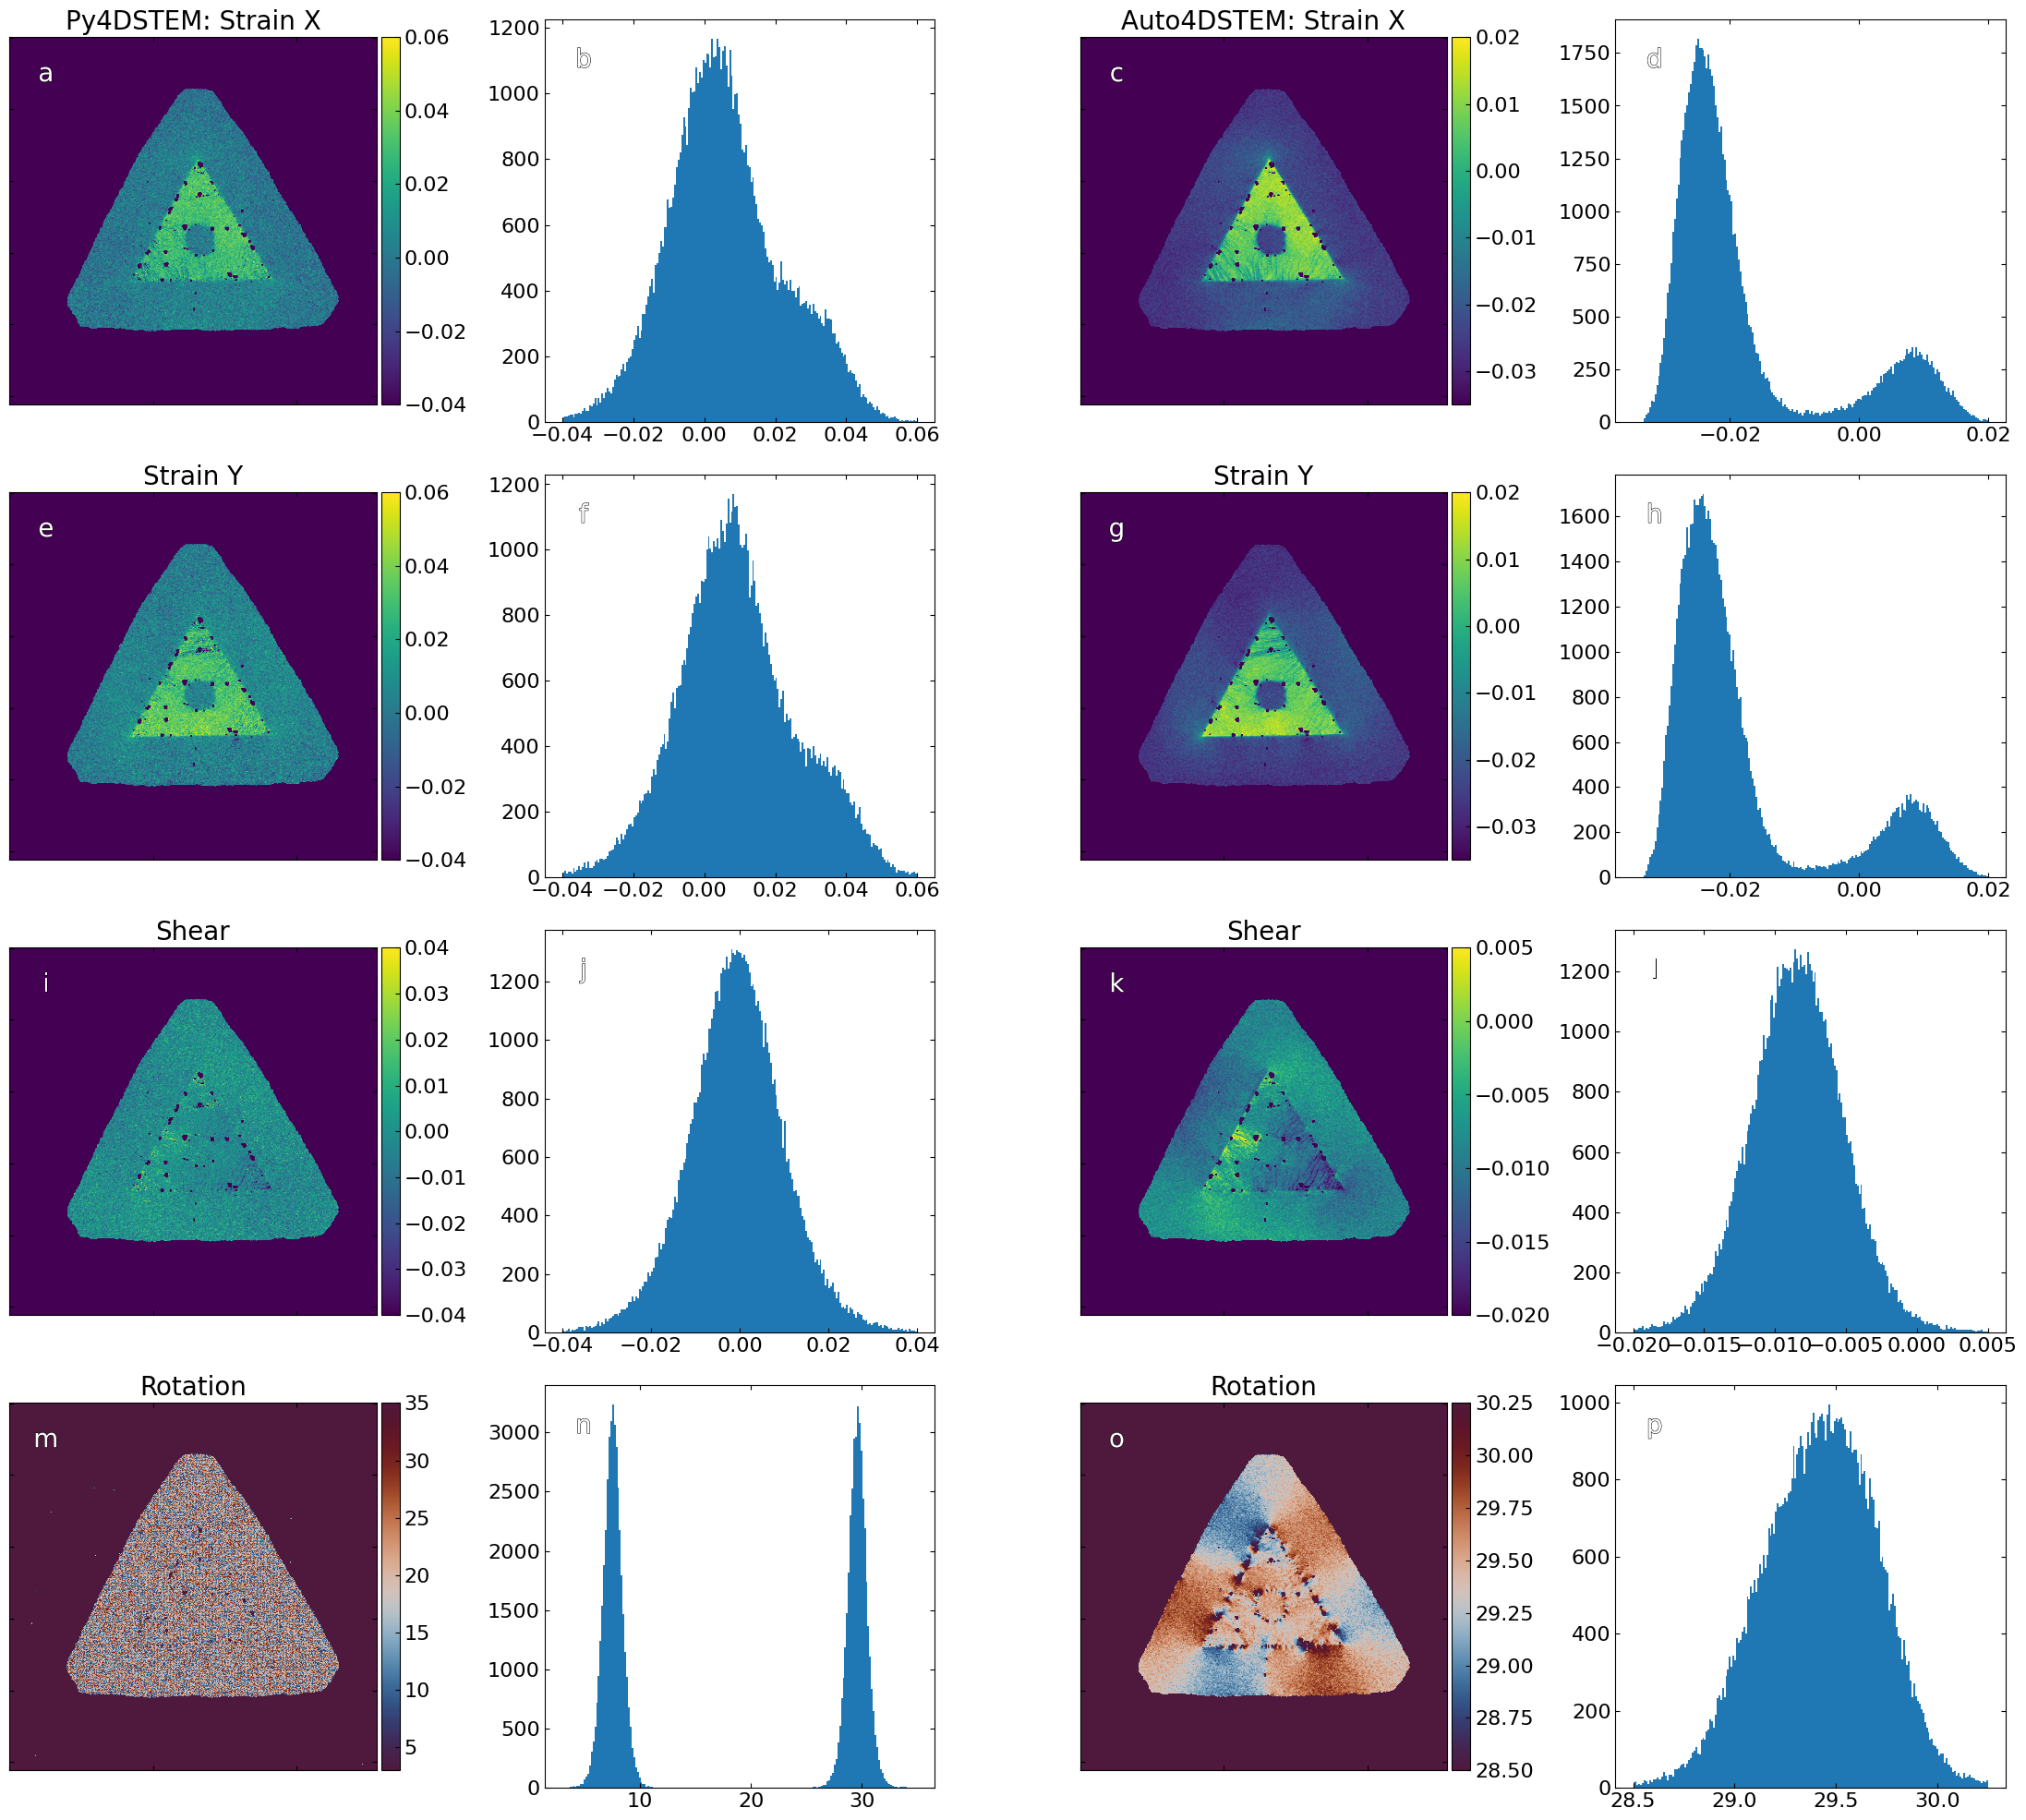

In [59]:
visual_result.visual_strain(strain_range_xx_ae=[-0.035,0.02],
                            strain_range_yy_ae=[-0.035,0.02],
                            strain_range_xy_ae=[-0.02,0.005],
                            strain_range_xx_cross=[-0.04,0.06],
                            strain_range_yy_cross=[-0.04,0.06],
                            strain_range_xy_cross=[-0.04,0.04],
                            )

**Figure 14: Strain maps of Rot512 $WS_2WSe_2$ 4D-STEM measured with Py4DSTEM and Auto4DSTEM. a) Strain map and b) histogram in direction $ε_{xx}$ meansured with Py4DSTEM. e) Strain map and f) histogram in direction $ε_{yy}$ meansured with Py4DSTEM. i) Strain map and j) histogram in direction $ε_{xy}$ meansured with Py4DSTEM. m) Strain map and n) histogram in rotation meansured with Py4DSTEM. c) Strain map and d) histogram in direction $ε_{xx}$ meansured with Auto4DSTEM. g) Strain map and h) histogram in direction $ε_{yy}$ meansured with Auto4DSTEM. k) Strain map and l) histogram in direction $ε_{xy}$ meansured with Auto4DSTEM. o) Strain map and p) histogram in rotation meansured with Auto4DSTEM.**

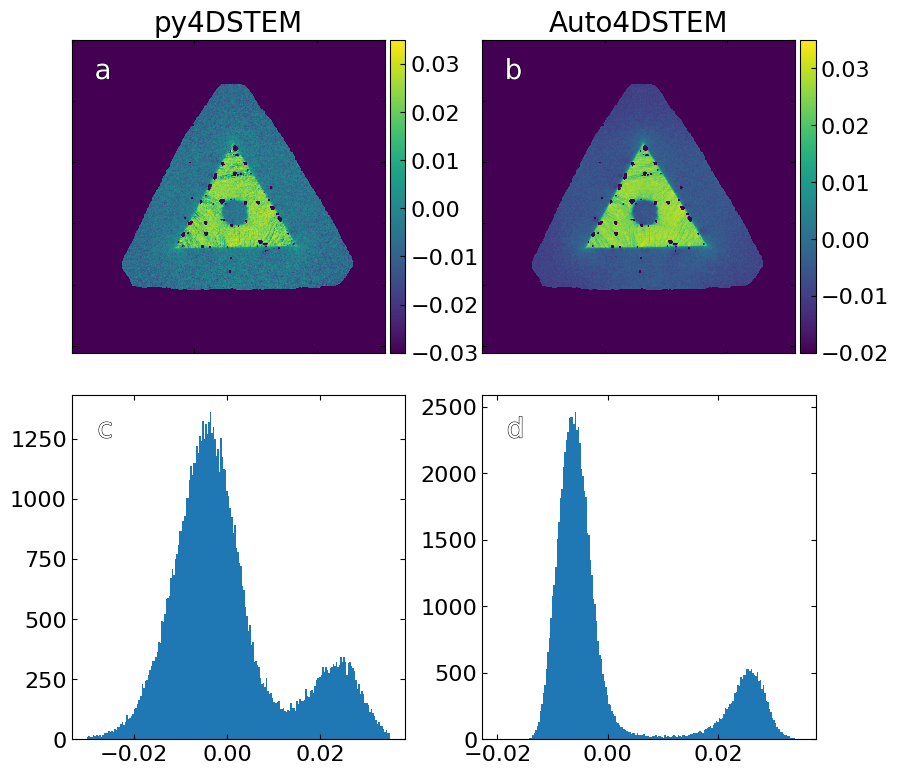

In [60]:
visual_result.visual_magnitude_of_strain(strain_range = [-0.02,0.035],
                                           ref_range = [-0.03,0.035])

**Figure 15: Strain magitude. a) Strain magnitude mapping on 4D-STEM and c) Corresponding histogram measursed with Py4DSTEM. b) Strain magnitude mapping on 4D-STEM and d) Corresponding histogram measursed with Auto4DSTEM.**